In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150

In [2]:
import h5py
import numpy as np
from itertools import product
import matplotlib.pyplot as pl
from scipy.linalg import cho_factor, cho_solve
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import FastICA, RandomizedPCA

In [29]:
with h5py.File("data/k2/superstamp.h5", "r") as f:
    time = f["time"][:]
    i = np.arange(len(time))[np.isnan(time)][-1] + 100
    time = time[i+1:]
    data = f["frames"][i+1:, :, :]
data[data == 0] = np.nan

In [30]:
m = np.isfinite(time) & np.any(np.isfinite(data), axis=(1, 2))
time = time[m]
data = data[m]

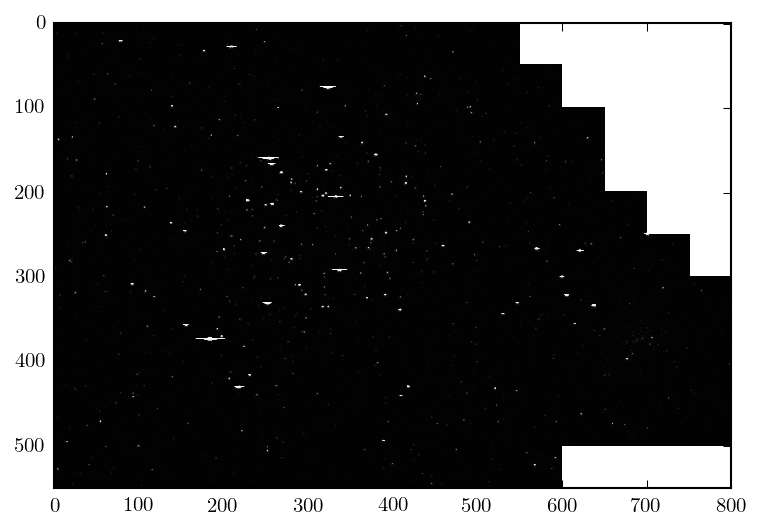

In [31]:
pl.imshow(data[0], cmap="gray", interpolation="nearest")

In [32]:
scaled = data  # / np.median(data, axis=0)[None, :, :]

In [33]:
X, Y = np.meshgrid(range(scaled.shape[1]), range(scaled.shape[2]), indexing="ij")
m = np.any(np.isfinite(scaled), axis=0)
pred = np.zeros_like(scaled)
count = np.zeros_like(scaled[0], dtype=int)
hw = 5
ex = hw + 10

xmn, xmx = 220, 239
ymn, ymx = 320, 341

# for i, j in product(range(0, scaled.shape[1], hw+1), range(0, scaled.shape[1], hw+1)):
for i, j in product(range(xmn, xmx, hw+1), range(ymn, ymx, hw+1)):
    # Select target and predictor pixels.
    window = m & (i - hw <= X) & (X <= i + hw) & (j - hw <= Y) & (Y <= j + hw)
    r2 = (X-i)**2 + (Y-j)**2
    others = m & ((i - ex > X) | (X > i + ex) | (j - ex > Y) | (Y > j + ex)) & (r2 < 40**2)
    print(i, j, window.sum(), others.sum())

    if not (np.any(window) and np.any(others)):
        continue

    # Split predictors into train and validate.
    flag = np.random.rand(others.sum()) < 0.5
    o1 = np.array(others)
    o1[others] = flag
    o2 = np.array(others)
    o2[others] = ~flag
    
    # Compute the emperical prior.
    A = np.concatenate((scaled[:, o1], np.ones((len(scaled), 1))), axis=1)
#     ATA = np.dot(A.T, A)
#     ATA[np.diag_indices_from(ATA)] += 1e-2
#     factor = cho_factor(ATA, overwrite_a=True)
#     w0 = cho_solve(factor, np.dot(A.T, scaled[:, o2]), overwrite_b=True)
#     emp = 1. / np.sqrt(np.mean(w0**2, axis=1))  # np.sqrt(np.median(w0**2, axis=1))
    
    # Compute the prediction.
    # A = np.concatenate((A, np.diag(emp)), axis=0)
    ATA = np.dot(A.T, A)
#     print(ATA)
#     assert 0
    ATA[np.diag_indices_from(ATA)] += 1e-2
    factor = cho_factor(ATA, overwrite_a=True)
    # y = np.concatenate((scaled[:, window], np.zeros((len(emp), window.sum()))), axis=0)
    y = scaled[:, window]
    w = cho_solve(factor, np.dot(A.T, y))

    pred[:, window] += np.dot(A[:len(scaled)], w)
    count[window] += 1

220 320 121 4052
220 326 121 4052
220 332 121 4052
220 338 121 4052
226 320 121 4052
226 326 121 4052
226 332 121 4052
226 338 121 4052
232 320 121 4052
232 326 121 4052
232 332 121 4052
232 338 121 4052
238 320 121 4052
238 326 121 4052
238 332 121 4052
238 338 121 4052


In [34]:
pred[:, count > 0] /= count[count > 0]

In [35]:
d = (scaled[:, xmn:xmx, ymn:ymx] - pred[:, xmn:xmx, ymn:ymx])
np.unravel_index(np.argmax(np.abs(d)), d.shape)

(933, 9, 3)

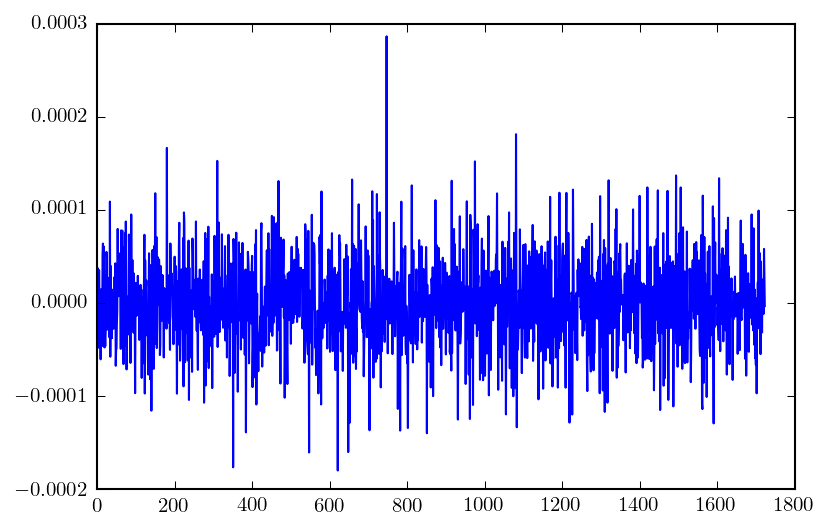

In [36]:
pl.plot(d[:, 12, 18])

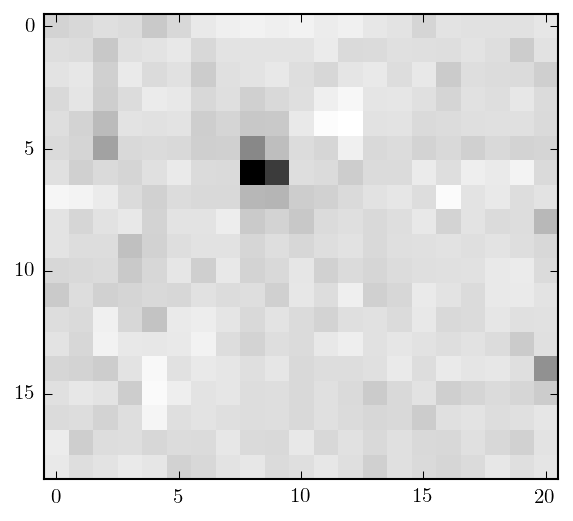

In [37]:
n = 0
pl.imshow(data[n, xmn:xmx, ymn:ymx] - pred[n, xmn:xmx, ymn:ymx], cmap="gray", interpolation="nearest")

In [40]:
d = data[:, xmn:xmx, ymn:ymx] - pred[:, xmn:xmx, ymn:ymx]
block = d.reshape((len(d), -1))
# block = block / np.median(block, axis=0) - 1

In [41]:
model = FastICA(n_components=10)
model.fit(block.T)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=10, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [42]:
n = len(model.components_)
print(n)

10


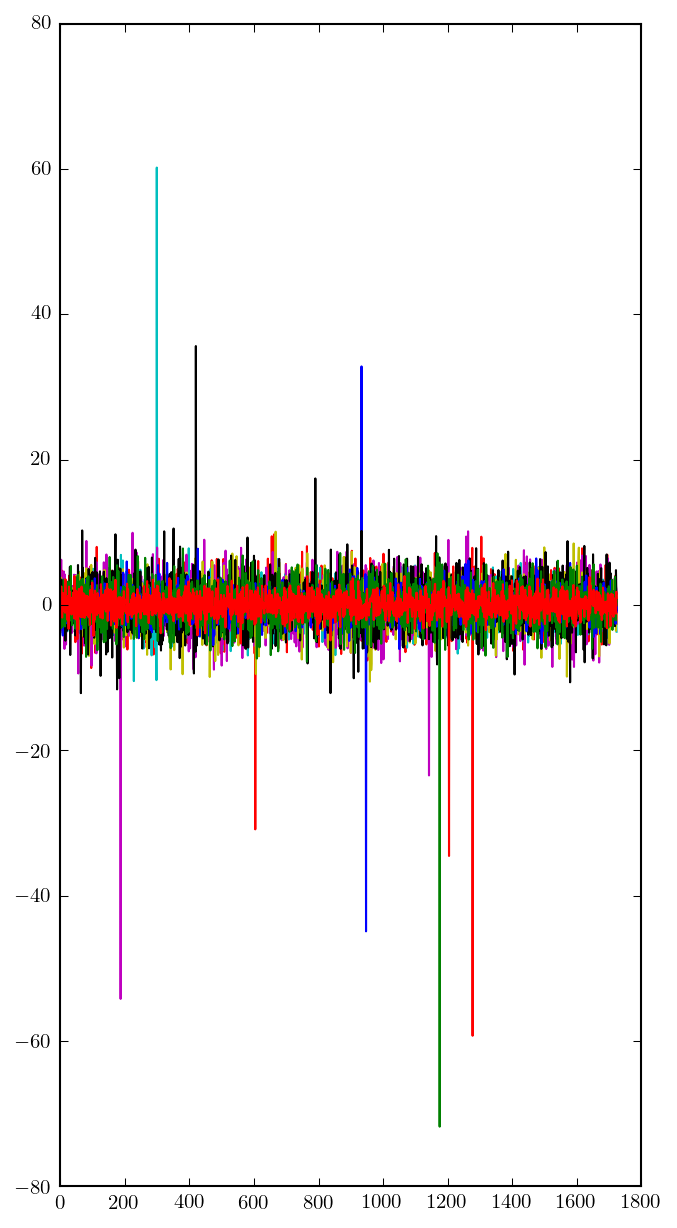

In [43]:
pl.figure(figsize=(5, 10))
pl.plot(model.components_.T + 1e-6*np.arange(n));

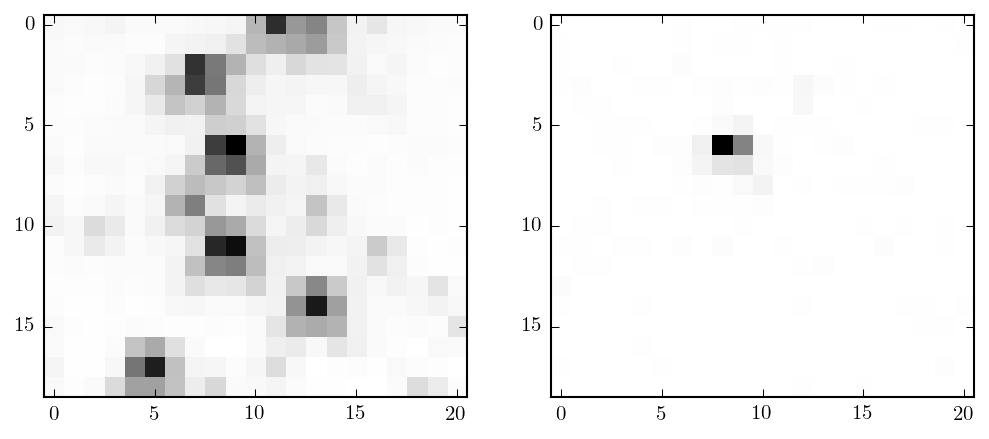

In [65]:
fig, axes = pl.subplots(1, 2, figsize=(8, 4))
v = model.components_[1]
comp = np.abs((np.dot(v, block)).reshape(d[0].shape))

axes[0].imshow(np.log(data[0, xmn:xmx, ymn:ymx]), cmap="gray_r", interpolation="nearest")
axes[1].imshow(comp, cmap="gray_r", interpolation="nearest")

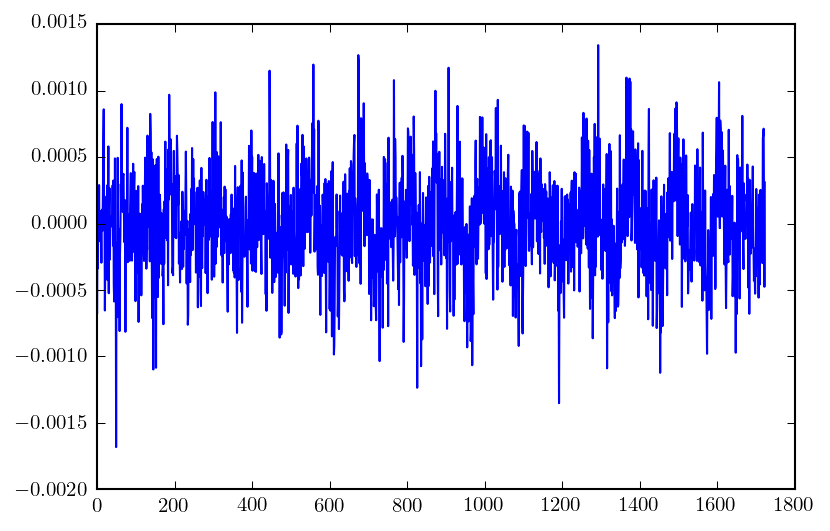

In [66]:
c = np.dot(v, block)
c /= np.sum(c)
pl.plot(np.sum(c * block, axis=1))

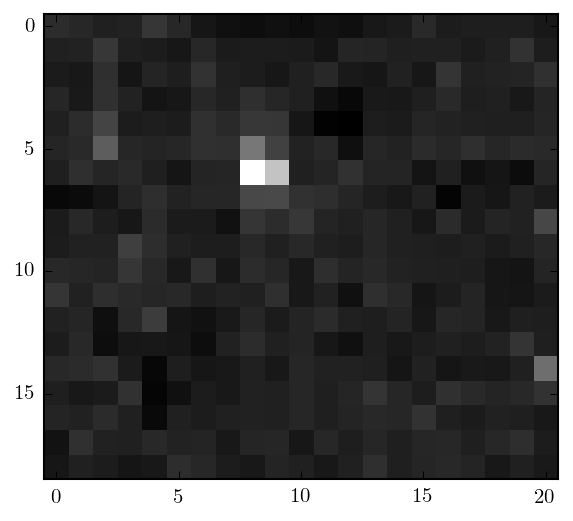

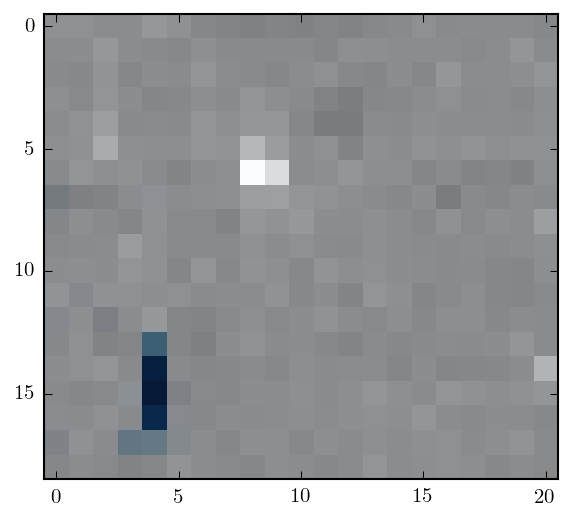

In [64]:
pl.figure()
pl.imshow(d[0], cmap="gray_r", interpolation="nearest")
pl.figure()
pl.imshow(d[0], cmap="gray_r", interpolation="nearest")
pl.imshow(comp, cmap="Blues", interpolation="nearest", alpha=0.5);